Saved: sim_gmm_regimes.csv


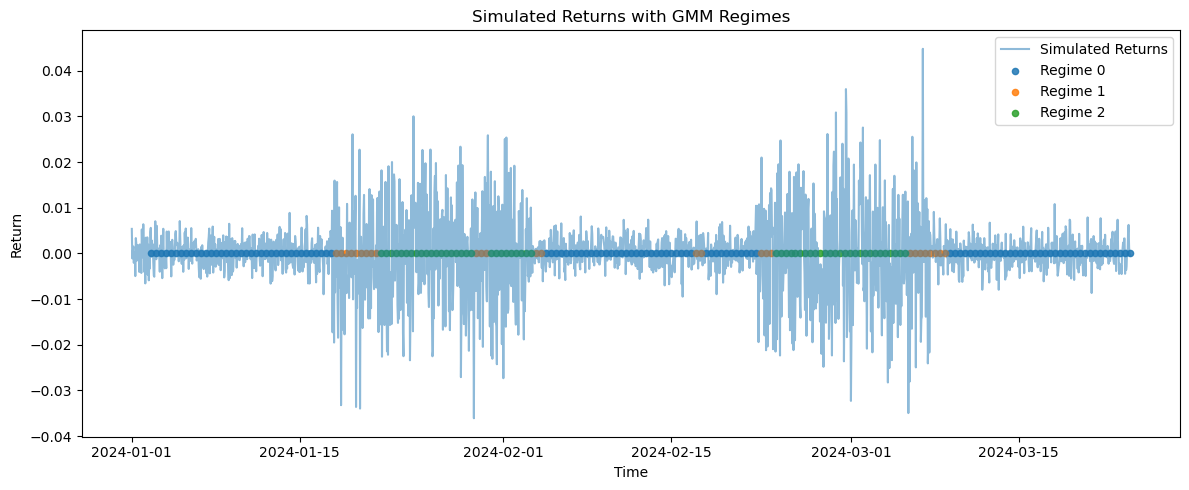

<Figure size 1200x400 with 0 Axes>

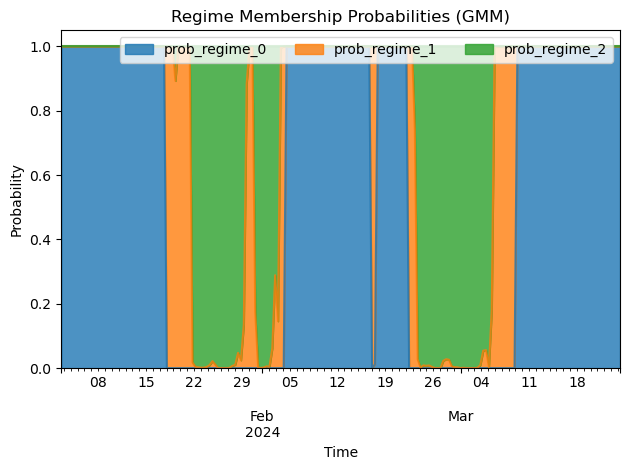

                 time  regime  prob_regime_0  prob_regime_1  prob_regime_2  \
0 2024-01-02 15:00:00       0            1.0   7.203782e-09   1.137920e-11   
1 2024-01-03 01:00:00       0            1.0   1.683915e-08   5.841174e-13   
2 2024-01-03 11:00:00       0            1.0   9.568157e-08   1.966797e-12   
3 2024-01-03 21:00:00       0            1.0   5.362865e-09   1.198303e-15   
4 2024-01-04 07:00:00       0            1.0   1.073448e-08   5.404800e-16   

             mu     sigma      skew      kurt  mean_abs      acf1  
0 -7.153363e-07  0.003244  0.007746 -0.438553  0.002533 -0.226495  
1 -1.057567e-04  0.003406  0.142284 -0.440105  0.002692 -0.073029  
2  2.729242e-04  0.003498  0.018643 -0.545492  0.002755 -0.013165  
3 -1.442715e-04  0.003327  0.296052 -0.492136  0.002641  0.068927  
4  2.282093e-04  0.003155  0.159727 -0.361075  0.002416  0.150681  


In [ ]:
# Simulated Regime Classification with GMM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import datetime as dt

def segment_time_series(series: np.ndarray, window: int = 40, step: int = 10):
    """Slice 1D array into overlapping windows; returns (segments, start_indices)."""
    segs, starts = [], []
    N = len(series)
    for s in range(0, N - window + 1, step):
        segs.append(series[s:s + window])
        starts.append(s)
    return np.asarray(segs), np.asarray(starts)

def acf_1(x: np.ndarray) -> float:
    """Lag-1 autocorrelation (safe for constant segments)."""
    x = np.asarray(x) - np.asarray(x).mean()
    denom = float(np.dot(x, x))
    if denom == 0.0:
        return 0.0
    return float(np.dot(x[:-1], x[1:]) / denom)

def extract_features(segments: np.ndarray) -> pd.DataFrame:
    """Compute features per segment."""
    rows = []
    for seg in segments:
        mu = float(np.mean(seg))
        sigma = float(np.std(seg, ddof=1))
        sk = skew(seg, bias=False)
        kur = kurtosis(seg, fisher=True, bias=False)  # excess kurtosis
        mean_abs = float(np.mean(np.abs(seg)))
        a1 = acf_1(seg)
        rows.append([
            mu,
            sigma,
            float(sk) if np.isfinite(sk) else 0.0,
            float(kur) if np.isfinite(kur) else 0.0,
            mean_abs,
            float(a1),
        ])
    return pd.DataFrame(rows, columns=["mu","sigma","skew","kurt","mean_abs","acf1"])

def remap_labels_by_vol(hard_labels: np.ndarray, feat_df: pd.DataFrame):
    """
    Remap labels so new label 0 has the lowest average sigma, then 1, 2, ...
    Returns remapped labels and mapping dicts.
    """
    tmp = pd.DataFrame({"lab": hard_labels, "sigma": feat_df["sigma"].values})
    avg_sigma = tmp.groupby("lab")["sigma"].mean().sort_values()  # ascending
    mapping = {old: new for new, old in enumerate(avg_sigma.index.to_list())}
    inv = {v: k for k, v in mapping.items()}
    remapped = np.vectorize(mapping.get)(hard_labels)
    return remapped, mapping, inv

# Demo

def simulate_and_classify(
    N=2000,                # number of timesteps
    window=40, step=10,    # segmentation parameters
    k=2,                   # number of GMM regimes
    seed=7,
    csv_path="sim_gmm_regimes.csv"
):
    np.random.seed(seed)

    # Build a piecewise-constant true regime path
    true_regimes = np.zeros(N, dtype=int)
    switch_points = [400, 800, 1250, 1600]  # alternate regimes
    for i, sp in enumerate(switch_points):
        true_regimes[sp:] = 1 if (i % 2 == 0) else 0

    # Regime parameters (per-step return distribution)
    mu = np.array([0.0003, -0.0001])    # mean
    sigma = np.array([0.003, 0.012])    # volatility

    # Generate returns according to regime
    rets = np.zeros(N)
    for t in range(N):
        rets[t] = np.random.normal(mu[true_regimes[t]], sigma[true_regimes[t]])

    # Time index (hourly for illustration)
    start_time = dt.datetime(2024, 1, 1)
    times = np.array([start_time + dt.timedelta(hours=i) for i in range(N)])

    # Segment and feature engineering
    segments, starts = segment_time_series(rets, window=window, step=step)
    if len(segments) == 0:
        raise RuntimeError("No segments created. Adjust window/step or increase N.")
    feat_df = extract_features(segments).astype(float)

    # Standardize features and fit GMM
    X = feat_df.to_numpy()
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(Xs)

    hard = gmm.predict(Xs)
    probs = gmm.predict_proba(Xs)

    # Remap labels so 0 = lowest-vol regime (by sigma feature)
    hard_ordered, mapping, inv_mapping = remap_labels_by_vol(hard, feat_df)

    # Timestamp for each segment (use end of window)
    end_idx = starts + window - 1
    regime_times = times[end_idx]

    # Build output table
    out = pd.DataFrame({"time": regime_times, "regime": hard_ordered})
    for i in range(k):
        old = inv_mapping[i]
        out[f"prob_regime_{i}"] = probs[:, old]
    out = pd.concat([out, feat_df.reset_index(drop=True)], axis=1)

    # Save CSV
    if csv_path:
        out.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")

    # Plot 1: returns + regime dots 
    plt.figure(figsize=(12,5))
    plt.plot(times, rets, alpha=0.5, label="Simulated Returns")
    for lab in np.unique(hard_ordered):
        m = (hard_ordered == lab)
        plt.scatter(regime_times[m], np.zeros(m.sum()), s=20, alpha=0.85, label=f"Regime {lab}")
    plt.title("Simulated Returns with GMM Regimes")
    plt.xlabel("Time"); plt.ylabel("Return"); plt.legend()
    plt.tight_layout(); plt.show()

    # Plot 2: stacked soft probabilities
    plt.figure(figsize=(12,4))
    prob_cols = [f"prob_regime_{i}" for i in range(k)]
    out.set_index("time")[prob_cols].sort_index().plot(kind="area", stacked=True, alpha=0.8)
    plt.title("Regime Membership Probabilities (GMM)")
    plt.xlabel("Time"); plt.ylabel("Probability"); plt.legend(loc="upper right", ncol=min(k,4))
    plt.tight_layout(); plt.show()

    return out, gmm, scaler

if __name__ == "__main__":
    df, gmm, scaler = simulate_and_classify(
        N=2000,      # increase for longer series
        window=40,   # window size for features
        step=10,     # stride between windows
        k=3,         # try 3 for calm/normal/crisis
        seed=7,
        csv_path="sim_gmm_regimes.csv"
    )
    print(df.head())

